In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Carregar o dataset
df_salario = pd.read_csv('./datasets/dataset_salario.csv')

In [5]:
# inspecionar a estrutura do dataframe
df_salario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tempo_na_empresa  1000 non-null   int64  
 1   nivel_na_empresa  1000 non-null   int64  
 2   salario_em_reais  1000 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 23.6 KB


In [6]:
# Copiar DF para DF EDA
df_salario_eda = df_salario.copy()

In [7]:
# Copiar DF para DF Bucketing
df_salario_bucketing = df_salario.copy()

### EDA

In [8]:
# Detectar valores ausentes
df_salario_eda.isna().sum()

tempo_na_empresa    0
nivel_na_empresa    0
salario_em_reais    0
dtype: int64

In [9]:
df_salario_eda.describe()

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
count,1000.000000,1000.000000,1000.000000
mean,59.712000,5.467000,5093.726110
std,34.027679,2.889509,4536.168857
min,1.000000,1.000000,538.560000
25%,30.750000,3.000000,1537.477500
50%,60.000000,6.000000,3237.920000
75%,89.000000,8.000000,7436.680000
max,120.000000,10.000000,18923.230000


<Axes: xlabel='tempo_na_empresa'>

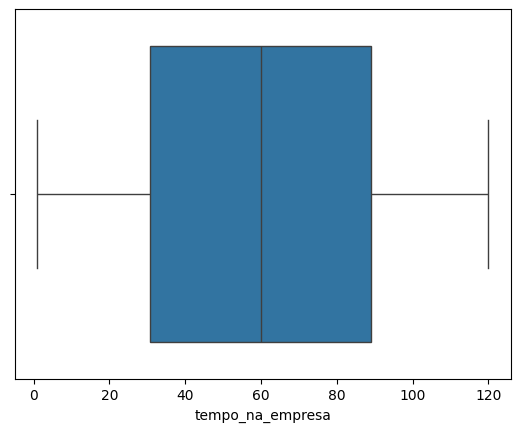

In [10]:
sns.boxplot(data=df_salario_eda, x='tempo_na_empresa')

<Axes: xlabel='nivel_na_empresa'>

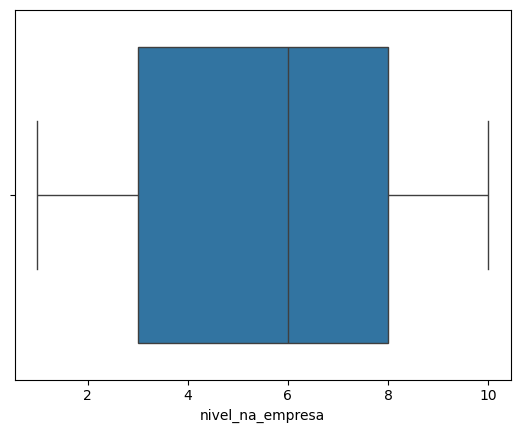

In [11]:
sns.boxplot(data=df_salario_eda, x='nivel_na_empresa')

<Axes: xlabel='salario_em_reais'>

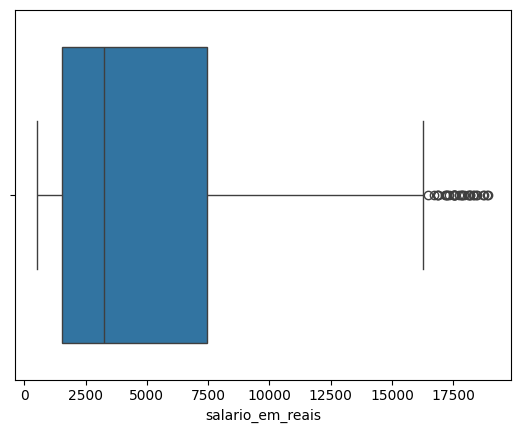

In [12]:
sns.boxplot(data=df_salario_eda, x='salario_em_reais')

<Axes: xlabel='tempo_na_empresa', ylabel='salario_em_reais'>

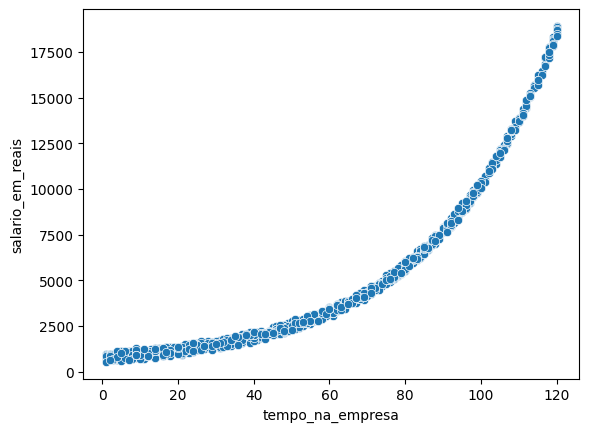

In [13]:
sns.scatterplot(data=df_salario_eda, x='tempo_na_empresa', y='salario_em_reais')

<Axes: xlabel='nivel_na_empresa', ylabel='salario_em_reais'>

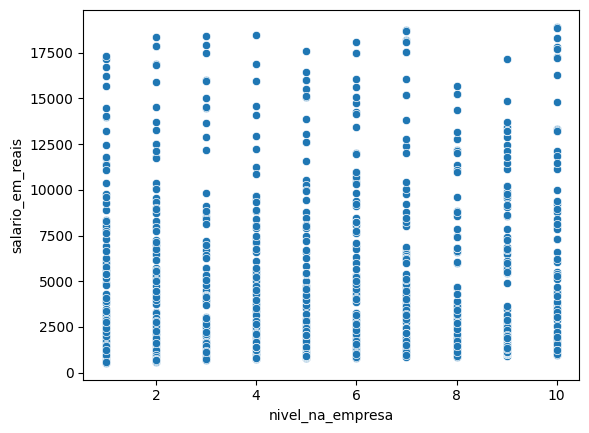

In [14]:
sns.scatterplot(data=df_salario_eda, x='nivel_na_empresa', y='salario_em_reais')

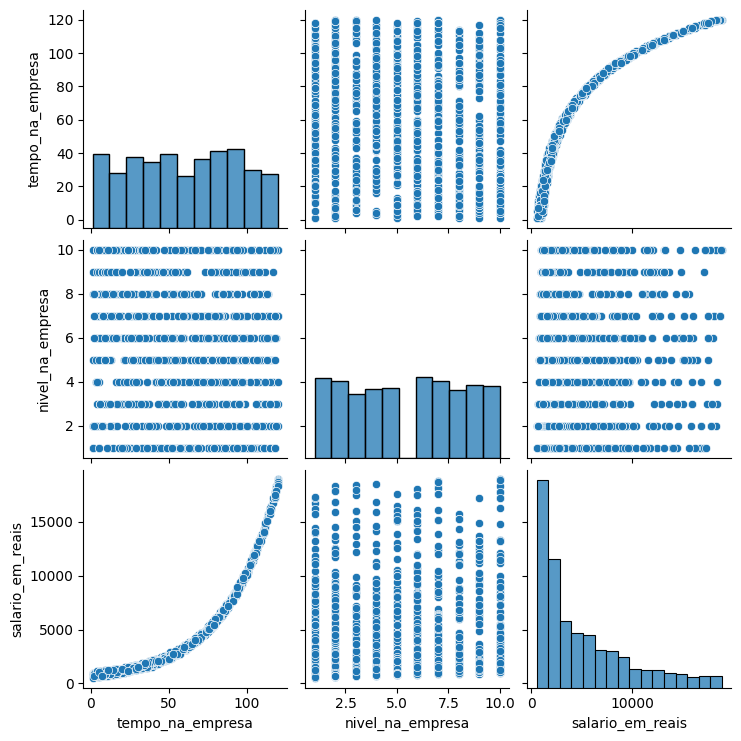

In [15]:
sns.pairplot(df_salario_eda)

<Axes: >

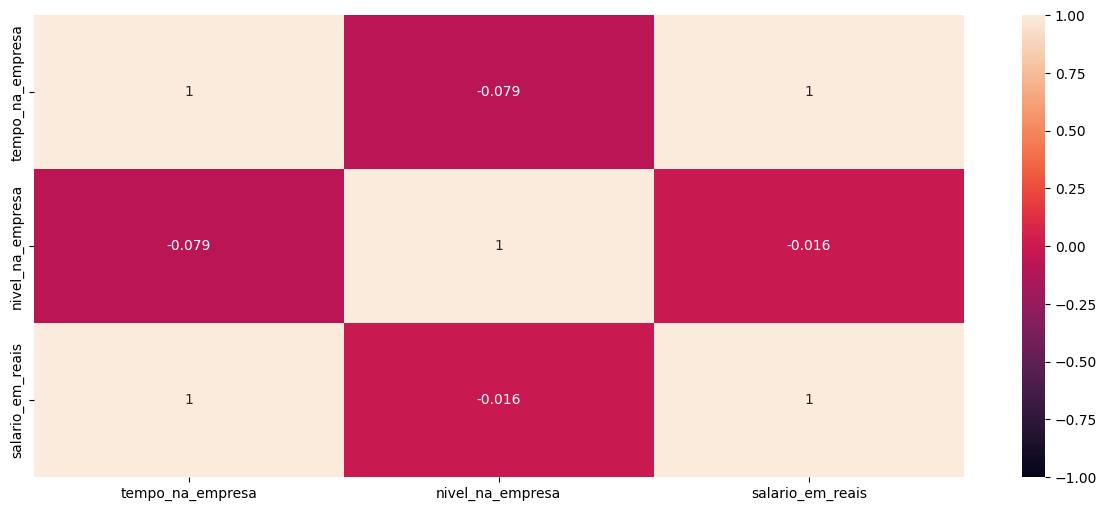

In [16]:
plt.figure(figsize=(15,6))
sns.heatmap(df_salario_eda.corr('spearman'), vmin=-1, vmax=1, annot=True)

<Axes: >

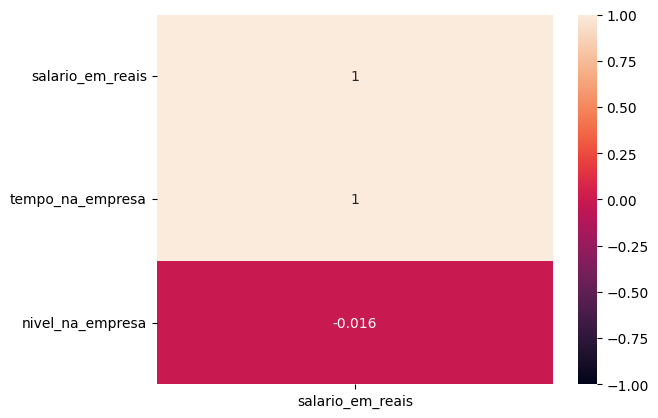

In [17]:
sns.heatmap(df_salario_eda.corr('spearman')[['salario_em_reais']].sort_values(by='salario_em_reais', ascending=False), vmin=-1, vmax=1, annot=True)

In [18]:
bins_tempo_casa = [0,10,20,30,40,50,60,70,80,90,100,110,120,130]
labels_tempo_casa = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99','100-109','110-119','120-129']
df_salario_bucketing['escala_tempo'] = pd.cut(x=df_salario_bucketing['tempo_na_empresa'],bins=bins_tempo_casa,labels=labels_tempo_casa,include_lowest=True)

<Axes: xlabel='escala_tempo', ylabel='salario_em_reais'>

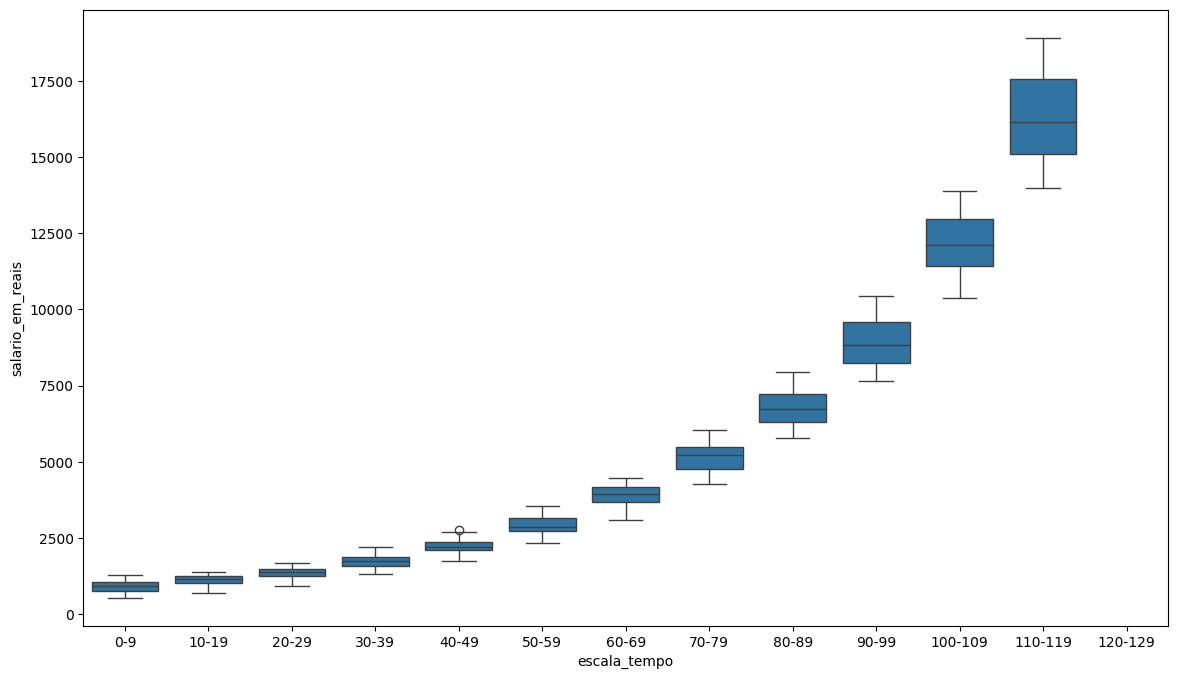

In [19]:
plt.figure(figsize=(14,8))
sns.boxplot(df_salario_bucketing, x='escala_tempo', y='salario_em_reais')

### Treinar Modelo Linear

In [25]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, root_mean_squared_error

import numpy as np

In [21]:
# Criar o dataset de treino e teste
X = df_salario.drop(columns='salario_em_reais', axis=1)
y = df_salario['salario_em_reais']

In [22]:
# Split usando Kflod em 5 pastas/splits
kf = KFold(n_splits=5, shuffle=True, random_state=51)

In [28]:
# Bloco para treinamento do modelo

# Pipeline
# Padronizar variaveis numericas - tempo_na_empresa, nivel_na_empresa

# NOmes das colunas
colunas_numericas = ['tempo_na_empresa', 'nivel_na_empresa']

# Transformer para Colunas numericas
transformer_numericas = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Criar um column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numericas, colunas_numericas)
    ]
)

# Criando um pipeline principal = Pre processamento + treinamento
model_regr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Armazenar RMSE Treino e Teste
rmse_scores_fold_train = []
rmse_scores_fold_test = []

# Armazenar R2 Score de Teste
r2score_fold_test = []

# Armazenas residuos
residuos = []

# Armazenar predições
y_pred_total = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_regr.fit(X_train, y_train)

    # Faça predições nos conjuntos de treinamento e Teste
    y_train_pred = model_regr.predict(X_train)
    y_test_pred = model_regr.predict(X_test)

    # Calcule o RMSE para os conjuntos de treinamento
    rmse_train = root_mean_squared_error(y_train, y_train_pred)
    rmse_test = root_mean_squared_error(y_test, y_test_pred)
    r2score_test = r2_score(y_test, y_test_pred)
    residuos_test = np.array(y_test - y_test_pred)

    rmse_scores_fold_train.append(rmse_train)
    rmse_scores_fold_test.append(rmse_test)
    r2score_fold_test.append(r2score_test)
    residuos.append(residuos_test)
    y_pred_total.append(y_test_pred)

rmse_train_final = np.mean(rmse_scores_fold_train)
rmse_test_final = np.mean(rmse_scores_fold_test)
r2score_test_final = np.mean(r2score_fold_test)
percent_rmse_final = ((rmse_test_final - rmse_train_final) / rmse_train_final) * 100
residuos = np.array(residuos).reshape(-1)
y_pred_total = np.array(y_pred_total).reshape(-1)

### Análise de Métricas - Modelo Linear

In [ ]:
# Métricas
print(f'RMSE Treino: {rmse_train_final}')
print(f'RMSE Teste: {rmse_test_final}')
print(f'Dif. RMSE Treino e Teste: {percent_rmse_final}')
print(f'R2Score Teste: {r2score_test_final}')

RMSE Treino: 1882.8318426651392
RMSE Teste: 1886.4504221336076
Dif. RMSE Treino e Teste: 0.19218813844503052
R2Score Teste: 0.8261178870584761


In [29]:
# Métricas
print(f'RMSE Treino: {rmse_train_final}')
print(f'RMSE Teste: {rmse_test_final}')
print(f'Dif. RMSE Treino e Teste: {percent_rmse_final}')
print(f'R2Score Teste: {r2score_test_final}')

RMSE Treino: 1882.8318426651392
RMSE Teste: 1886.4504221336076
Dif. RMSE Treino e Teste: 0.19218813844503052
R2Score Teste: 0.8261178870584761


### Analise de residuos - Modelo Linear

In [30]:
# Transformar residuos na escala padrão
# (X - media) / desvio padrão
from scipy.stats import zscore
residuos_std = zscore(residuos)

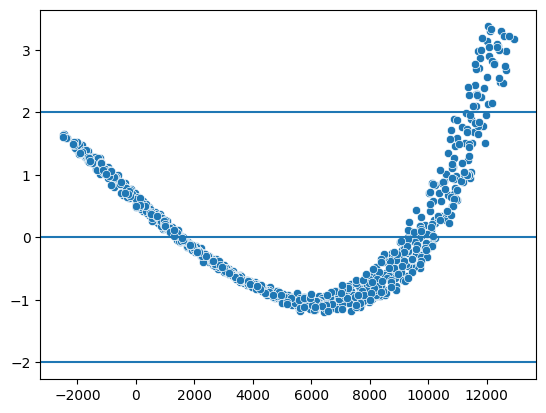

In [31]:
# Verificar linearidade dos residuos: Valores entre -2 e +2 (escala padrão)
# Verificar homocedasticidade: Valores em torno da reta sem nenhuma rendência ou formato
sns.scatterplot(x=y_pred_total, y=residuos_std)
plt.axhline(y=0)
plt.axhline(y=-2)
plt.axhline(y=2)

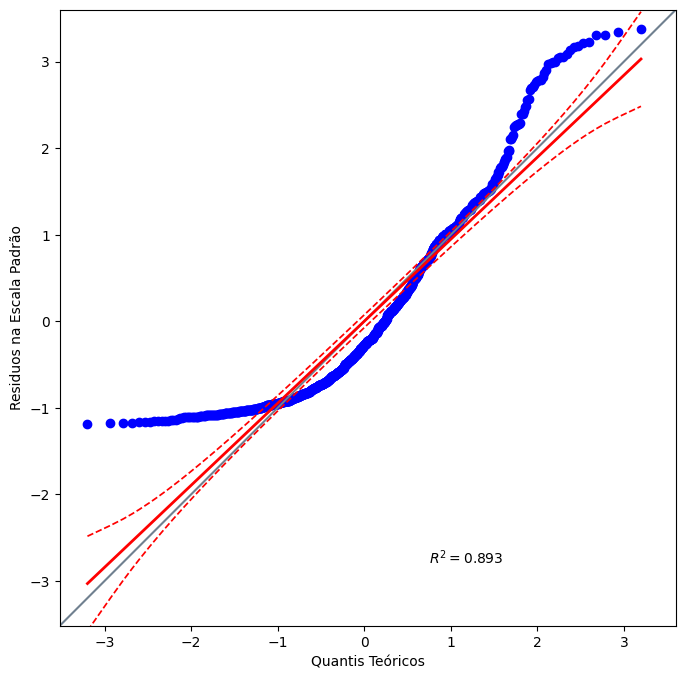

In [32]:
# Checar se residuos seguem uma distribuição normal
# QQ plot
import pingouin as pg
plt.figure(figsize=(14,8))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis Teóricos')
plt.ylabel('Residuos na Escala Padrão')
plt.show()

In [33]:
# Teste de Normalidade - Shapiro Wilk: Não seguem uma distribuição normal
from scipy.stats import shapiro, kstest
from statsmodels.stats.diagnostic import lilliefors
stat_shapiro, p_value_shapiro = shapiro(residuos)
print(f'Estat. Teste {stat_shapiro} e P-Value {p_value_shapiro}')

Estat. Teste 0.891969217965228 e P-Value 7.013497918013492e-26


In [34]:
# Teste de Normalidade - Kolmogorov-Smirnov: Não seguem uma distribuição normal
stat_ks, p_value_ks = kstest(residuos, 'norm')
print(f'Estat. Teste {stat_ks} e P-Value {p_value_ks}')

Estat. Teste 0.5939999999999955 e P-Value 0.0


In [35]:
# Teste de Normalidade - Liliefors: Não seguem uma distribuição normal
stat_ll, p_value_ll = lilliefors(residuos, dist='norm', pvalmethod='table')
print(f'Estat. Teste {stat_ll} e P-Value {p_value_ll}')

Estat. Teste 0.11825983774680088 e P-Value 0.0009999999999998899


## Treinar Modelo Polinomial

In [38]:
# Exemplo de Criação de Features Polinomiais
feat_poly = PolynomialFeatures(degree=3, include_bias=True)
X_poly = feat_poly.fit_transform(X)
feat_poly.feature_names_in_

array(['tempo_na_empresa', 'nivel_na_empresa'], dtype=object)

In [39]:
feat_poly.get_feature_names_out(feat_poly.feature_names_in_)

array(['1', 'tempo_na_empresa', 'nivel_na_empresa', 'tempo_na_empresa^2',
       'tempo_na_empresa nivel_na_empresa', 'nivel_na_empresa^2',
       'tempo_na_empresa^3', 'tempo_na_empresa^2 nivel_na_empresa',
       'tempo_na_empresa nivel_na_empresa^2', 'nivel_na_empresa^3'],
      dtype=object)

In [43]:
# Bloco para treinamento do modelo

# graus_polymonial = [1,2,3,4,5,6,7,8,9,10]
graus_polymonial = [4]

rmse_train_values = []
rmse_test_values = []
percentual_rmse_values = []
r2score_test_values = []

# Split usando Kflod em 5 pastas/splits
kf = KFold(n_splits=5, shuffle=True, random_state=51)

for grau in graus_polymonial:

    # Pipeline
    # Padronizar variaveis numericas - tempo_na_empresa, nivel_na_empresa

    # NOmes das colunas
    colunas_numericas = ['tempo_na_empresa', 'nivel_na_empresa']

    # Transformer para Colunas numericas
    transformer_numericas = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # Criar um column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', transformer_numericas, colunas_numericas)
        ]
    )

    # Criar features polinomiais
    poly_feat = PolynomialFeatures(degree=grau, include_bias=False)

    # Criando um pipeline principal = Pre processamento + treinamento
    model_poly = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('poly_features', poly_feat),
        ('regressor', LinearRegression())
    ])

    # Armazenar RMSE Treino e Teste
    rmse_scores_fold_train = []
    rmse_scores_fold_test = []

    # Armazenar R2 Score de Teste
    r2score_fold_test = []

    # Armazenas residuos
    residuos = []

    # Armazenar predições
    y_pred_total = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_poly.fit(X_train, y_train)

        # Faça predições nos conjuntos de treinamento e Teste
        y_train_pred = model_poly.predict(X_train)
        y_test_pred = model_poly.predict(X_test)

        # Calcule o RMSE para os conjuntos de treinamento
        rmse_train = root_mean_squared_error(y_train, y_train_pred)
        rmse_test = root_mean_squared_error(y_test, y_test_pred)
        r2score_test = r2_score(y_test, y_test_pred)
        residuos_test = np.array(y_test - y_test_pred)

        rmse_scores_fold_train.append(rmse_train)
        rmse_scores_fold_test.append(rmse_test)
        r2score_fold_test.append(r2score_test)
        residuos.append(residuos_test)
        y_pred_total.append(y_test_pred)

    rmse_train_final = np.mean(rmse_scores_fold_train)
    rmse_test_final = np.mean(rmse_scores_fold_test)
    r2score_test_final = np.mean(r2score_fold_test)
    percent_rmse_final = ((rmse_test_final - rmse_train_final) / rmse_train_final) * 100
    residuos = np.array(residuos).reshape(-1)
    y_pred_total = np.array(y_pred_total).reshape(-1)

    rmse_train_values.append(rmse_train_final)
    rmse_test_values.append(rmse_test_final)
    percentual_rmse_values.append(percent_rmse_final)
    r2score_test_values.append(r2score_test_final)

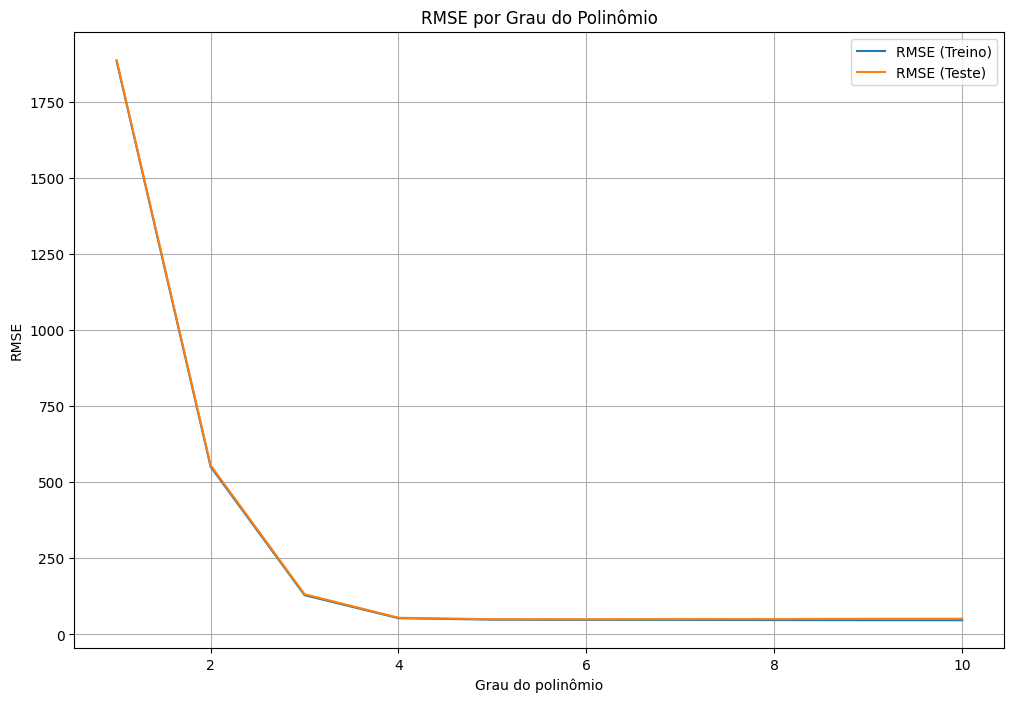

In [41]:
# Plot GRafico para comparar RMSE por Grau de Polinomio
plt.figure(figsize=(12,8))
plt.plot(graus_polymonial, rmse_train_values, label='RMSE (Treino)')
plt.plot(graus_polymonial, rmse_test_values, label='RMSE (Teste)')
plt.xlabel('Grau do polinômio')
plt.ylabel('RMSE')
plt.title('RMSE por Grau do Polinômio')
plt.legend()
plt.grid(True)
plt.show()

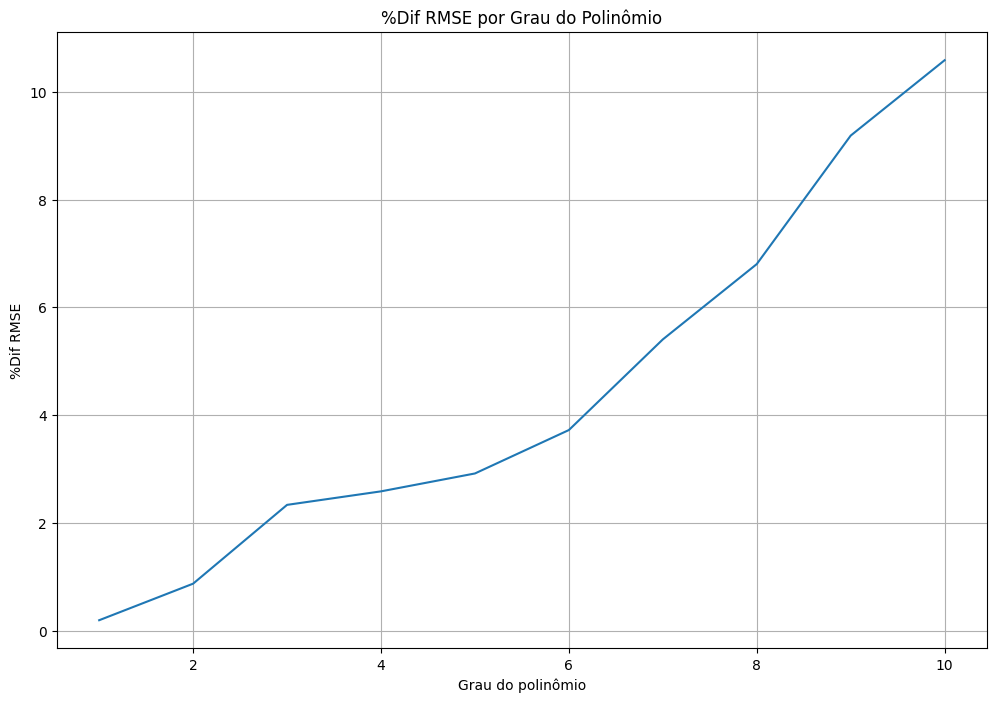

In [42]:
# Plot GRafico para comparar %Dif RMSE (Treino e Teste)
plt.figure(figsize=(12,8))
plt.plot(graus_polymonial, percentual_rmse_values, label='%Dif RMSE Treino e Teste')
plt.xlabel('Grau do polinômio')
plt.ylabel('%Dif RMSE')
plt.title('%Dif RMSE por Grau do Polinômio')
plt.grid(True)
plt.show()

### Análise de Métricas - Modelo Polinomial

In [44]:
# Métricas
print(f'RMSE Treino: {rmse_train_final}')
print(f'RMSE Teste: {rmse_test_final}')
print(f'Dif. RMSE Treino e Teste: {percent_rmse_final}')
print(f'R2Score Teste: {r2score_test_final}')

RMSE Treino: 53.32698559565161
RMSE Teste: 54.70504352796304
Dif. RMSE Treino e Teste: 2.5841661907546576
R2Score Teste: 0.9998524123039415


### Analise de residuos - Modelo Polinomial

In [45]:
# Transformar residuos na escala padrão
# (X - media) / desvio padrão
from scipy.stats import zscore
residuos_std = zscore(residuos)

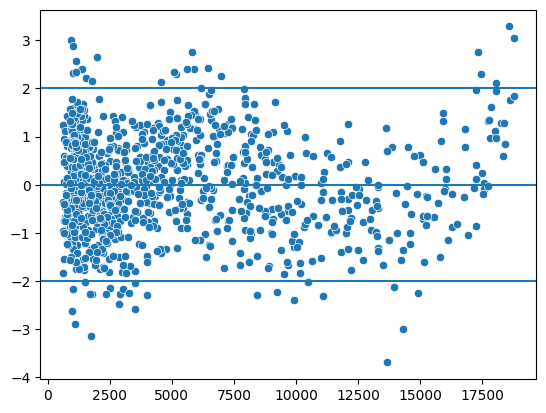

In [46]:
# Verificar linearidade dos residuos: Valores entre -2 e +2 (escala padrão)
# Verificar homocedasticidade: Valores em torno da reta sem nenhuma rendência ou formato
sns.scatterplot(x=y_pred_total, y=residuos_std)
plt.axhline(y=0)
plt.axhline(y=-2)
plt.axhline(y=2)

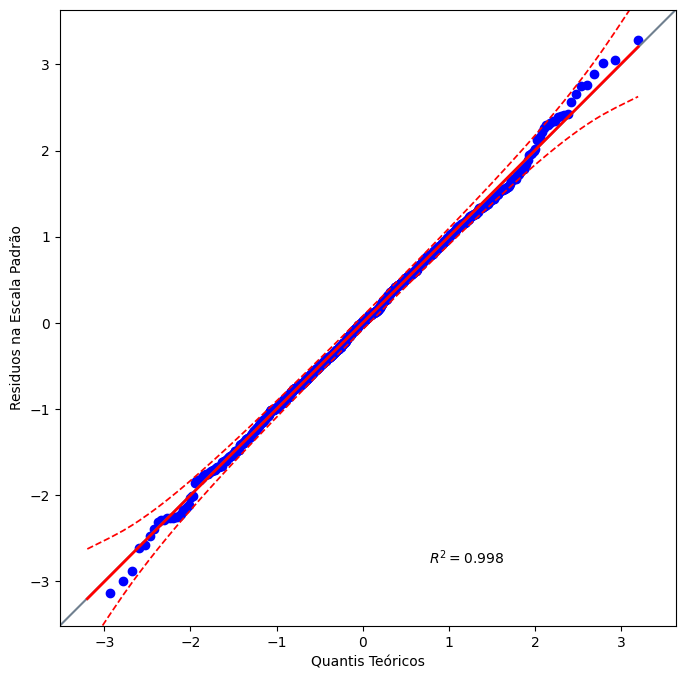

In [47]:
# Checar se residuos seguem uma distribuição normal
# QQ plot
import pingouin as pg
plt.figure(figsize=(14,8))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis Teóricos')
plt.ylabel('Residuos na Escala Padrão')
plt.show()

In [48]:
# Teste de Normalidade - Shapiro Wilk: Seguem uma distribuição normal
from scipy.stats import shapiro, kstest
from statsmodels.stats.diagnostic import lilliefors
stat_shapiro, p_value_shapiro = shapiro(residuos)
print(f'Estat. Teste {stat_shapiro} e P-Value {p_value_shapiro}')

Estat. Teste 0.9986951372205322 e P-Value 0.6852797159659514


In [49]:
# Teste de Normalidade - Kolmogorov-Smirnov: Não seguem uma distribuição normal
stat_ks, p_value_ks = kstest(residuos, 'norm')
print(f'Estat. Teste {stat_ks} e P-Value {p_value_ks}')

Estat. Teste 0.48237446499530856 e P-Value 1.2202460106524514e-214


In [50]:
# Teste de Normalidade - Liliefors: Seguem uma distribuição normal
stat_ll, p_value_ll = lilliefors(residuos, dist='norm', pvalmethod='table')
print(f'Estat. Teste {stat_ll} e P-Value {p_value_ll}')

Estat. Teste 0.013637346894986191 e P-Value 0.9566270022044506


## Realizar predições individuais

In [53]:
input_features = {
    'tempo_na_empresa': 80,
    'nivel_na_empresa': 5
}

pred_df = pd.DataFrame(input_features, index=[1])

In [54]:
# Predição
model_poly.predict(pred_df)

array([5747.79896506])

In [55]:
import joblib

In [56]:
# Salvar modelo
joblib.dump(model_poly, './modelo_salario.pkl')

['./modelo_salario.pkl']